<a href="https://colab.research.google.com/github/zeinabghannam/Knowledge.Distillation.For.Assistive.Health.Blind.People/blob/main/Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation Experiment for compressing computer vision models(CNN) for assistive technology device for visually impaired.

### Dissertation Code- Zeinab Ghannam



## Setup

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=4c4282e2ae1aead40f7d75c2d546ff827610720b0bf9cd9cf13221119400754b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
tf.random.set_seed(3)

import cv2
import imghdr

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras import metrics

from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy


import cv2

from tensorflow.keras.models import load_model


import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
wandb.init(settings=wandb.Settings(start_method="thread"))

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# path_to_data = "/content/drive/MyDrive/datasets_colab/mini_clean_10_labels_256X3_nursing"
path_to_data ="/content/drive/MyDrive/datasets_colab/final_100__mini_clean_10_labels_256X3_nursing"

data = tf.keras.utils.image_dataset_from_directory(path_to_data)

Found 1017 files belonging to 10 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

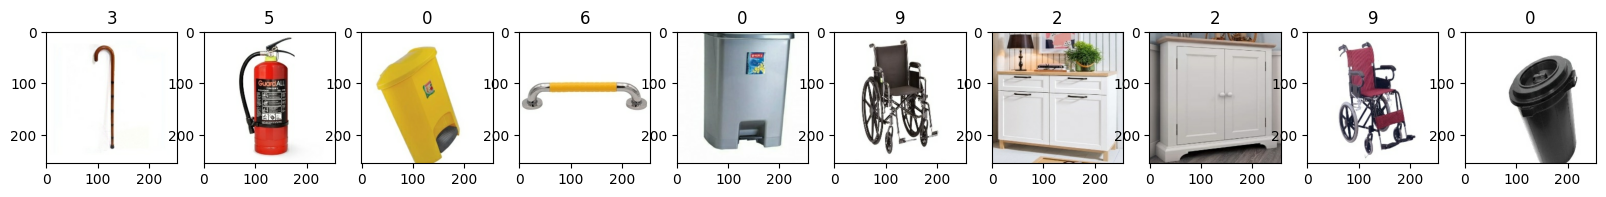

In [ ]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
# Normalizing the data: pixels values:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
# spliting the data to training, validating and testing (cross-validation to avoid overfitting)
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
# Hyperparameters:

input_shape = (256,256,3)


config={
           "conv_1_filter_size" : (3,3),
           "conv_1_no_filters" : 16,
           "conv_2_filter_size" : (3,3),
           "conv_2_no_filters" : 32,
           "conv_3_filter_size" : (3,3),
           "conv_3_no_filters" : 16,
           "conv_activation_fn" : 'relu',
            "dense_1_no_neurons": 256,
            "dense_1_activation_fn": "relu",
            "dropout": 0.5,
            "dense_output_classes": 10,
            "dense_output_activation_fn": "softmax",
            "optimizer": "adam",
            "loss": "sparse_categorical_crossentropy",
            "metric": "accuracy",
            "epoch": 10,
            "batch_size": 32,
           "lr" : 0.001,
           }

# print(config["epoch"])

In [ ]:
wandb.init(
        project="Experiment_KD_2",
        # (optional) set entity to specify your username or team name
        # entity="my_team",
        config=config,
    )
config = wandb.config

In [ ]:
from tensorflow.python.eager.monitoring import Metric
from keras.api._v2.keras.losses import Loss

model = Sequential()

model.add(Conv2D(config.conv_1_no_filters, config.conv_1_filter_size, 1, activation=config.conv_activation_fn, input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(config.conv_2_no_filters, config.conv_2_filter_size, 1, activation=config.conv_activation_fn))
model.add(MaxPooling2D())
model.add(Conv2D(config.conv_3_no_filters, config.conv_3_filter_size, 1, activation=config.conv_activation_fn))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(config.dense_1_no_neurons, activation=config.dense_1_activation_fn))
model.add(Dense(config.dense_output_classes, activation=config.dense_output_activation_fn))

model.compile(config.optimizer, loss=config.loss, metrics=[config.metric])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
# Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
wandb_callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="Experiment_Teacher_Model{epoch:02d}"),
    ]

In [ ]:
hist = model.fit(train, batch_size=config.batch_size,epochs=config.epoch, validation_data=val)

# Mark the run as finished
wandb.finish()

Epoch 1/10
22/22 [==============================] - 124s 6s/step - loss: 2.3621 - accuracy: 0.2472 - val_loss: 1.7434 - val_accuracy: 0.4531
Epoch 2/10
22/22 [==============================] - 52s 2s/step - loss: 1.3123 - accuracy: 0.5866 - val_loss: 1.1029 - val_accuracy: 0.6328
Epoch 3/10
22/22 [==============================] - 51s 2s/step - loss: 0.7446 - accuracy: 0.7869 - val_loss: 0.5942 - val_accuracy: 0.7734
Epoch 4/10
22/22 [==============================] - 52s 2s/step - loss: 0.3997 - accuracy: 0.8906 - val_loss: 0.2294 - val_accuracy: 0.9531
Epoch 5/10
22/22 [==============================] - 54s 2s/step - loss: 0.2023 - accuracy: 0.9474 - val_loss: 0.1301 - val_accuracy: 0.9766
Epoch 6/10
22/22 [==============================] - 51s 2s/step - loss: 0.0925 - accuracy: 0.9773 - val_loss: 0.0646 - val_accuracy: 0.9922
Epoch 7/10
22/22 [==============================] - 50s 2s/step - loss: 0.0750 - accuracy: 0.9801 - val_loss: 0.0594 - val_accuracy: 0.9844
Epoch 8/10
22/22 [=

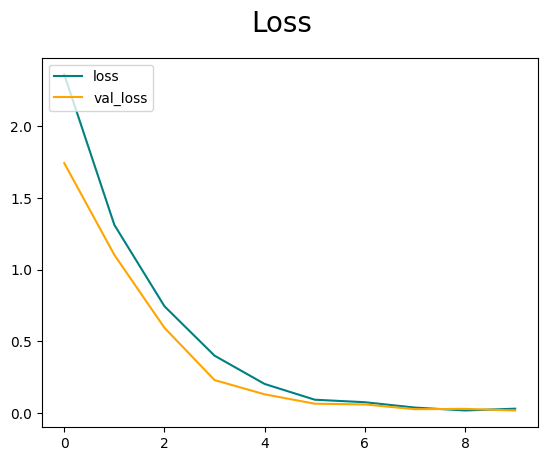

In [ ]:
### ------------------------
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


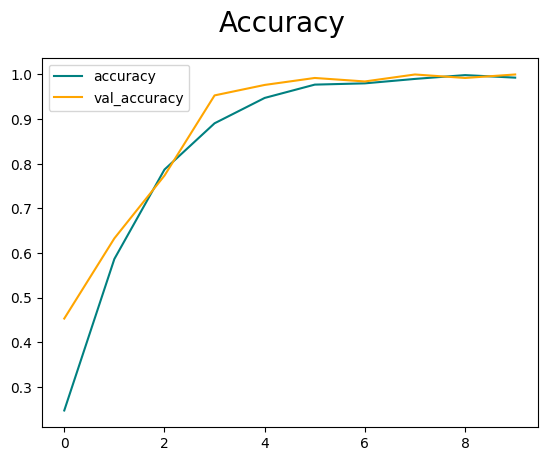

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    #yhat = model.predict(X)
    y_pred = model.predict(X)

    yhat = tf.argmax(y_pred, axis=1)

    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 572ms/step


In [ ]:
print("precision: ", pre.result())
print( "recall: ", re.result() )
print("accuracy: ", acc.result())


precision:  tf.Tensor(1.0, shape=(), dtype=float32)
recall:  tf.Tensor(1.0, shape=(), dtype=float32)
accuracy:  tf.Tensor(1.0, shape=(), dtype=float32)


## Construct `Distiller()` class that inherits Model class:


In [ ]:

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


### Create the student model
### teacher model has been created and trainined above.


In [ ]:
#  teacher model:
teacher = model

In [ ]:
student = Sequential()

student.add(Conv2D(8, config.conv_1_filter_size, 1, activation=config.conv_activation_fn, input_shape=(256,256,3)))
student.add(MaxPooling2D())
student.add(Conv2D(16, config.conv_2_filter_size, 1, activation=config.conv_activation_fn))
student.add(MaxPooling2D())
student.add(Conv2D(8, config.conv_3_filter_size, 1, activation=config.conv_activation_fn))
student.add(MaxPooling2D())
student.add(Flatten())

student.add(Dense(32, activation=config.dense_1_activation_fn))
student.add(Dense(config.dense_output_classes))


### scratch_student model, for comparison with the distilled student model.

In [ ]:
scratch_student = Sequential()

scratch_student.add(Conv2D(8, config.conv_1_filter_size, 1, activation=config.conv_activation_fn, input_shape=(256,256,3)))
scratch_student.add(MaxPooling2D())
scratch_student.add(Conv2D(16, config.conv_2_filter_size, 1, activation=config.conv_activation_fn))
scratch_student.add(MaxPooling2D())
scratch_student.add(Conv2D(8, config.conv_3_filter_size, 1, activation=config.conv_activation_fn))
scratch_student.add(MaxPooling2D())
scratch_student.add(Flatten())

scratch_student.add(Dense(32, activation=config.dense_1_activation_fn))
scratch_student.add(Dense(config.dense_output_classes))


In [ ]:
teacher.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
student.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 8)       

In [ ]:
scratch_student.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 8)         1160      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 8)       

## Prepare the dataset

The dataset used for training the teacher and distilling the teacher is
[MNIST](https://keras.io/api/datasets/mnist/), and the procedure would be equivalent for any other
dataset, e.g. [CIFAR-10](https://keras.io/api/datasets/cifar10/), with a suitable choice
of models. Both the student and teacher are trained on the training set and evaluated on
the test set.

## Train the teacher

In knowledge distillation we assume that the teacher is trained and fixed. Thus, we start
by training the teacher model on the training set in the usual way.

## Distill teacher to student

We have already trained the teacher model, and we only need to initialize a
`Distiller(student, teacher)` instance, `compile()` it with the desired losses,
hyperparameters and optimizer, and distill the teacher to the student.

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)

distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=40,
)

# Distill teacher to student
distiller.fit(train, batch_size=config.batch_size,epochs=config.epoch, validation_data=val)



Epoch 1/10
22/22 [==============================] - 52s 2s/step - sparse_categorical_accuracy: 0.2628 - student_loss: 2.0680 - distillation_loss: 9.0453e-05 - val_sparse_categorical_accuracy: 0.3359 - val_student_loss: 1.9474
Epoch 2/10
22/22 [==============================] - 52s 2s/step - sparse_categorical_accuracy: 0.5114 - student_loss: 1.4013 - distillation_loss: 6.3095e-04 - val_sparse_categorical_accuracy: 0.5234 - val_student_loss: 1.3630
Epoch 3/10
22/22 [==============================] - 52s 2s/step - sparse_categorical_accuracy: 0.7145 - student_loss: 0.9315 - distillation_loss: 0.0016 - val_sparse_categorical_accuracy: 0.7734 - val_student_loss: 0.6622
Epoch 4/10
22/22 [==============================] - 48s 2s/step - sparse_categorical_accuracy: 0.8452 - student_loss: 0.5571 - distillation_loss: 0.0028 - val_sparse_categorical_accuracy: 0.8281 - val_student_loss: 0.5644
Epoch 5/10
22/22 [==============================] - 49s 2s/step - sparse_categorical_accuracy: 0.9134 - 

## Train student from scratch for comparison

We can also train an equivalent student model from scratch without the teacher, in order
to evaluate the performance gain obtained by knowledge distillation.

In [ ]:
# Train student as done usually
scratch_student.compile(config.optimizer, loss=config.loss, metrics=[config.metric])

# Train and evaluate student trained from scratch.
scratch_student.fit(train, batch_size=config.batch_size,epochs=config.epoch, validation_data=val)

Epoch 1/10
22/22 [==============================] - 32s 1s/step - loss: 8.1608 - accuracy: 0.1506 - val_loss: 4.5631 - val_accuracy: 0.2422
Epoch 2/10
22/22 [==============================] - 32s 1s/step - loss: 2.8621 - accuracy: 0.2585 - val_loss: 2.7250 - val_accuracy: 0.1953
Epoch 3/10
22/22 [==============================] - 31s 1s/step - loss: 2.4140 - accuracy: 0.2188 - val_loss: 2.2346 - val_accuracy: 0.2031
Epoch 4/10
22/22 [==============================] - 33s 2s/step - loss: 2.2192 - accuracy: 0.2259 - val_loss: 2.3026 - val_accuracy: 0.1875
Epoch 5/10
22/22 [==============================] - 33s 1s/step - loss: 2.2675 - accuracy: 0.2003 - val_loss: 2.2846 - val_accuracy: 0.1719
Epoch 6/10
22/22 [==============================] - 31s 1s/step - loss: 2.2738 - accuracy: 0.1989 - val_loss: 2.3026 - val_accuracy: 0.1719
Epoch 7/10
22/22 [==============================] - 33s 2s/step - loss: 2.2737 - accuracy: 0.1918 - val_loss: 2.3026 - val_accuracy: 0.1641
Epoch 8/10
22/22 [==

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def save_keras_model(ml_model, filename):
    save_path = f"/content/drive/MyDrive/datasets_colab/models/{filename}"
    ml_model.save(filename + '.h5')
    print(f"Model saved to {filename}.h5")


In [ ]:
save_keras_model(teacher, 'teacher_model')

Model saved to teacher_model.h5


In [ ]:
save_keras_model(student, 'distilled_student_model')

Model saved to distilled_student_model.h5


In [ ]:
save_keras_model(scratch_student, 'scratch_student_model')

Model saved to scratch_student_model.h5


## Measuring the number of parameters, memory and computation, and making comparison.

In [ ]:
## document the result
print("teacher # parameters: ",teacher.count_params())
print("distilled # parameters: ",student.count_params())
print("scratch student # parameters: ",scratch_student.count_params())

teacher # parameters:  3698938
distilled # parameters:  233314
scratch student # parameters:  233314


In [ ]:
def bytes_to_readable(size):
    """Convert size in bytes to a human-readable format."""
    # Define the order of magnitude and the respective units
    powers = {'B': 0, 'KB': 1, 'MB': 2, 'GB': 3, 'TB': 4}
    unit = 'B'
    for key in powers:
        if size < 1024:
            unit = key
            break
        size /= 1024.0

    return f"{size:.2f} {unit}"

In [ ]:
def calculate_memory_size(model):
    # Sample a weight tensor to get its dtype
    sample_weight = model.trainable_weights[0]

    # Determine bytes per parameter based on dtype
    if sample_weight.dtype == tf.float32:
        dtype_size = 4
    elif sample_weight.dtype == tf.float16:
        dtype_size = 2
    elif sample_weight.dtype == tf.float64:
        dtype_size = 8
    # Add other dtypes as needed
    else:
        raise ValueError(f"Unsupported dtype: {sample_weight.dtype}")

    total_parameters = model.count_params()
    memory_in_bytes = total_parameters * dtype_size
    return memory_in_bytes


In [ ]:
print('memory size of trainable parameters')

print("teacher: ", bytes_to_readable(calculate_memory_size(teacher)))
print("distilled : ", bytes_to_readable(calculate_memory_size(student)))
print("scratch student: ", bytes_to_readable(calculate_memory_size(scratch_student)))

memory size of trainable parameters
teacher:  14.11 MB
distilled :  911.38 KB
scratch student:  911.38 KB
